## House Price Prediction

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# warnings.filterwarnings('ignore')

In [2]:
# Load training dataset
iowa_file_path = 'train.csv'
housing_df = pd.read_csv(iowa_file_path)
org_housing_df = pd.read_csv(iowa_file_path)
del iowa_file_path

In [3]:
# Inspect & understand data
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Change data type of MSSubClass, it is a categorical vairable however is entered as a numerical variable
housing_df['MSSubClass']= housing_df['MSSubClass'].astype('object')

In [5]:
## Check percentage of missing values
missing_info= round(housing_df.isna().sum() * 100/housing_df.shape[0], 2)
print(missing_info[missing_info > 0].sort_values(ascending= False))

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
MasVnrType      59.73
FireplaceQu     47.26
LotFrontage     17.74
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
Electrical       0.07
dtype: float64


In [6]:
# Drop columns with more than 95% missing values
housing_df.drop(columns=['PoolQC', 'MiscFeature'], inplace=True)

In [7]:
# Data Dictionary implies that NA for below features indicates that the feature is absent
# Replace NaN with 'Not Present' for those columns
valid_nan_cols= ['Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
                 'GarageCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']
housing_df[valid_nan_cols]= housing_df[valid_nan_cols].fillna('Not Present')

del valid_nan_cols

In [8]:
# Impute missing values of GarageYrBlt column
housing_df['GarageYrBlt']= housing_df['GarageYrBlt'].fillna(0)

In [9]:
numeric_columns = housing_df.select_dtypes(exclude='object').columns.to_list()
numeric_columns.pop(0)

'Id'

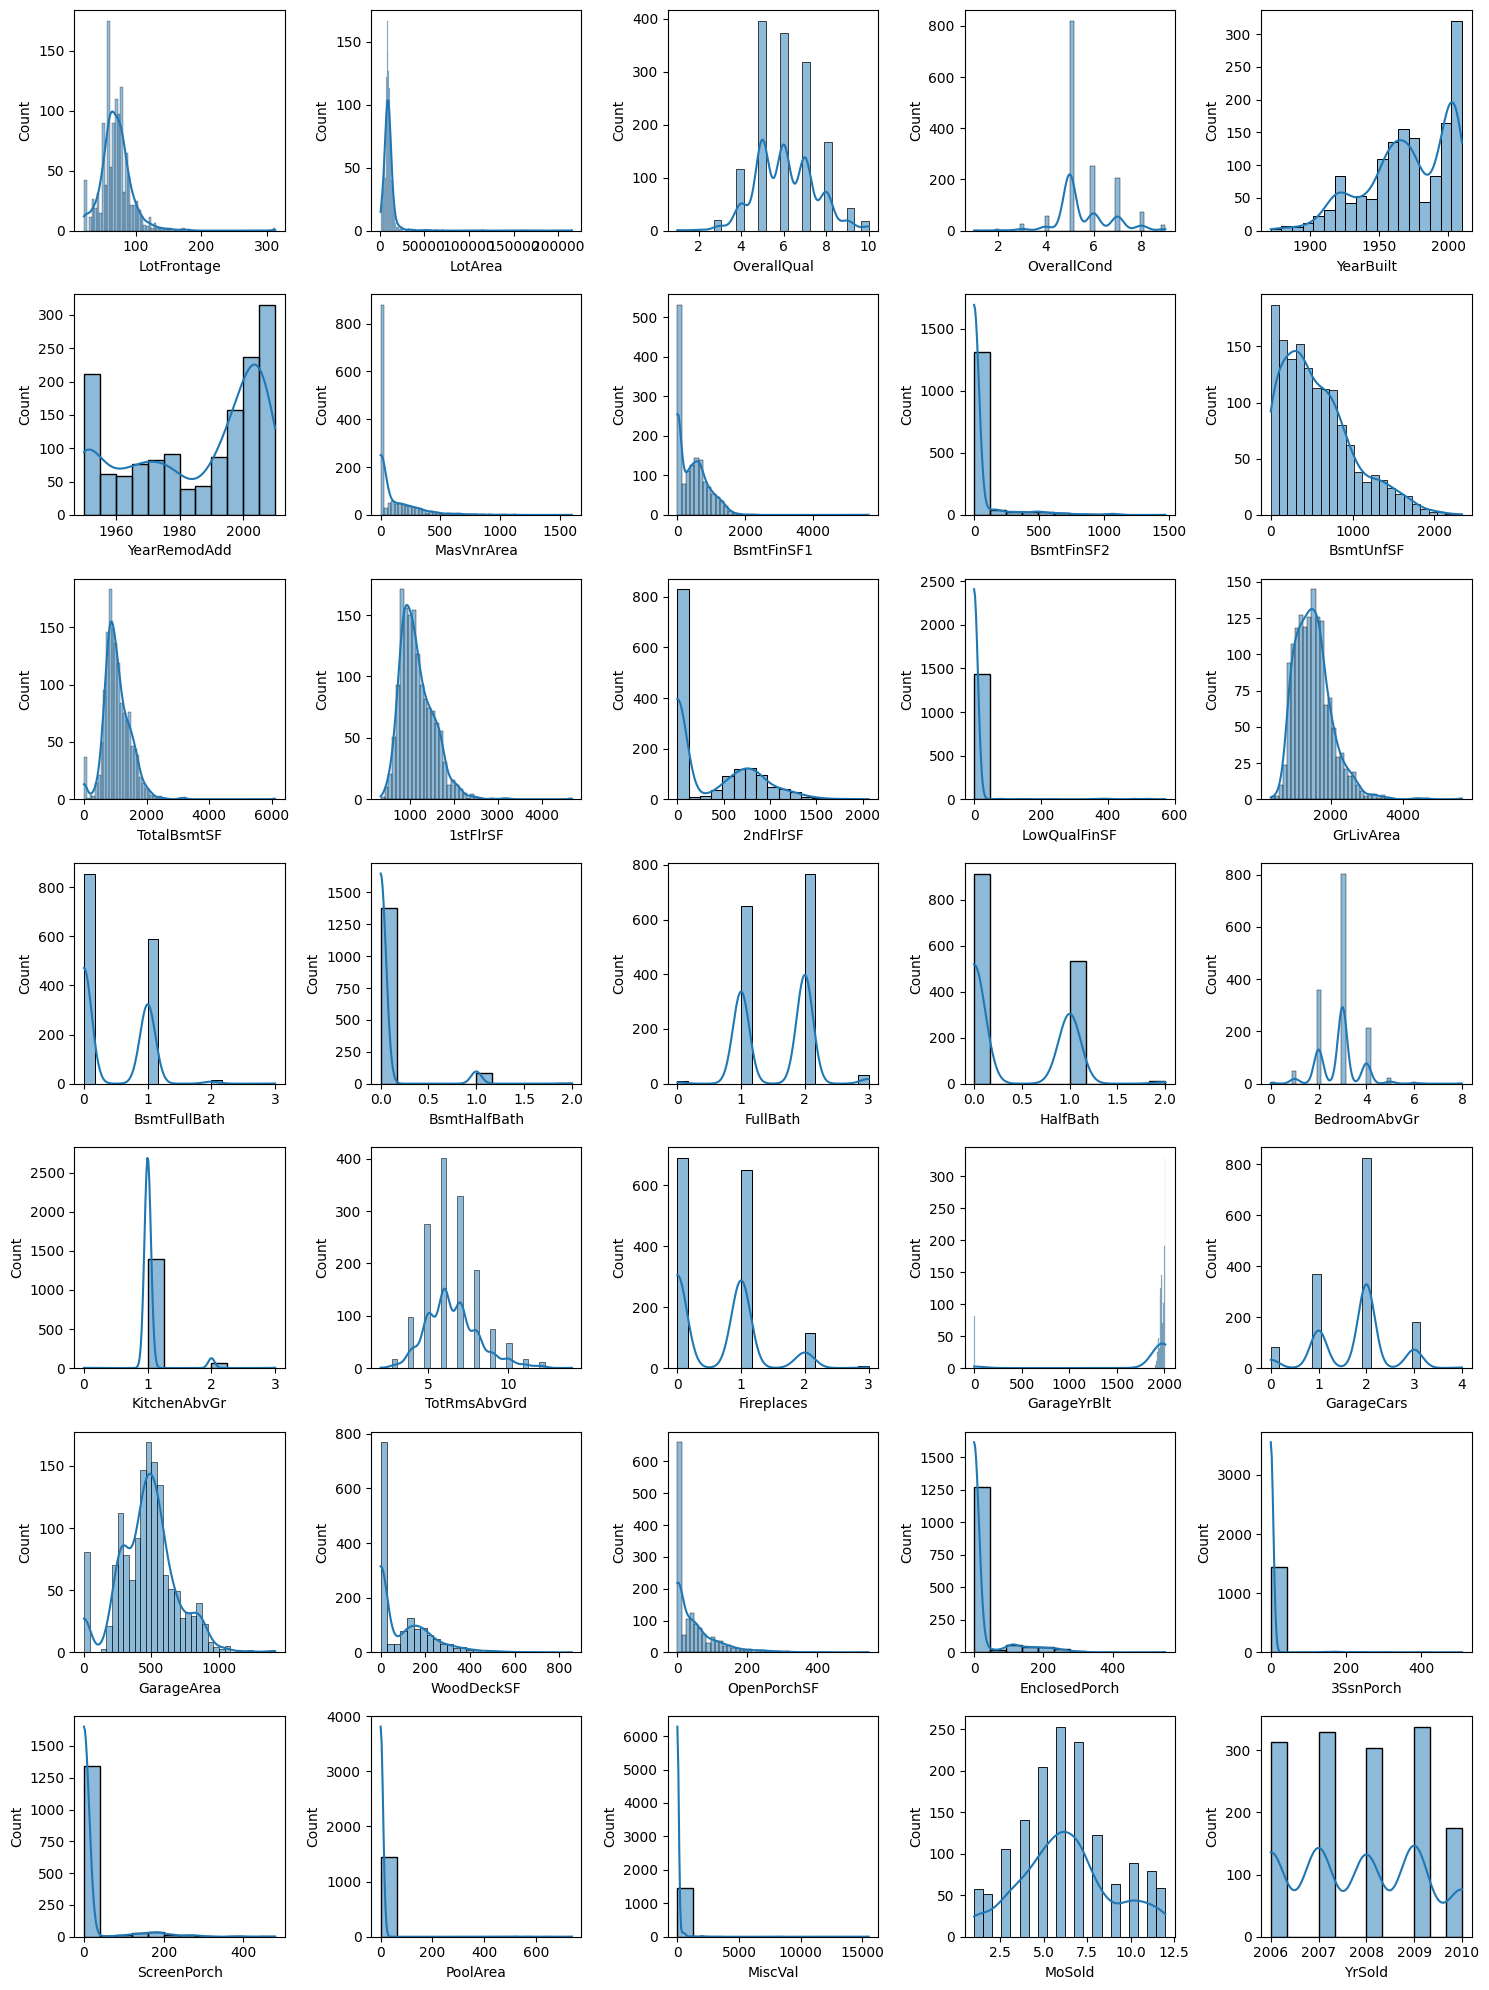

In [10]:
# Hist distribution of numerical features
n_rows = 7
n_cols = 5
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,20))

for i, column in enumerate(housing_df[numeric_columns]):
    if(column=='SalePrice'):
        break
    sns.histplot(housing_df[column], ax=axes[i//n_cols,i%n_cols], kde=True)

plt.tight_layout()
plt.show()

del n_rows, n_cols, fig, axes, i, column

In [11]:
# Drop highly skewed variables with a lot of zeros, based on histograms
col_drop = ["BsmtFinSF2", "LowQualFinSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]
housing_df.drop(columns=col_drop, inplace=True)
numeric_columns = [x for x in numeric_columns if x not in col_drop]
del col_drop

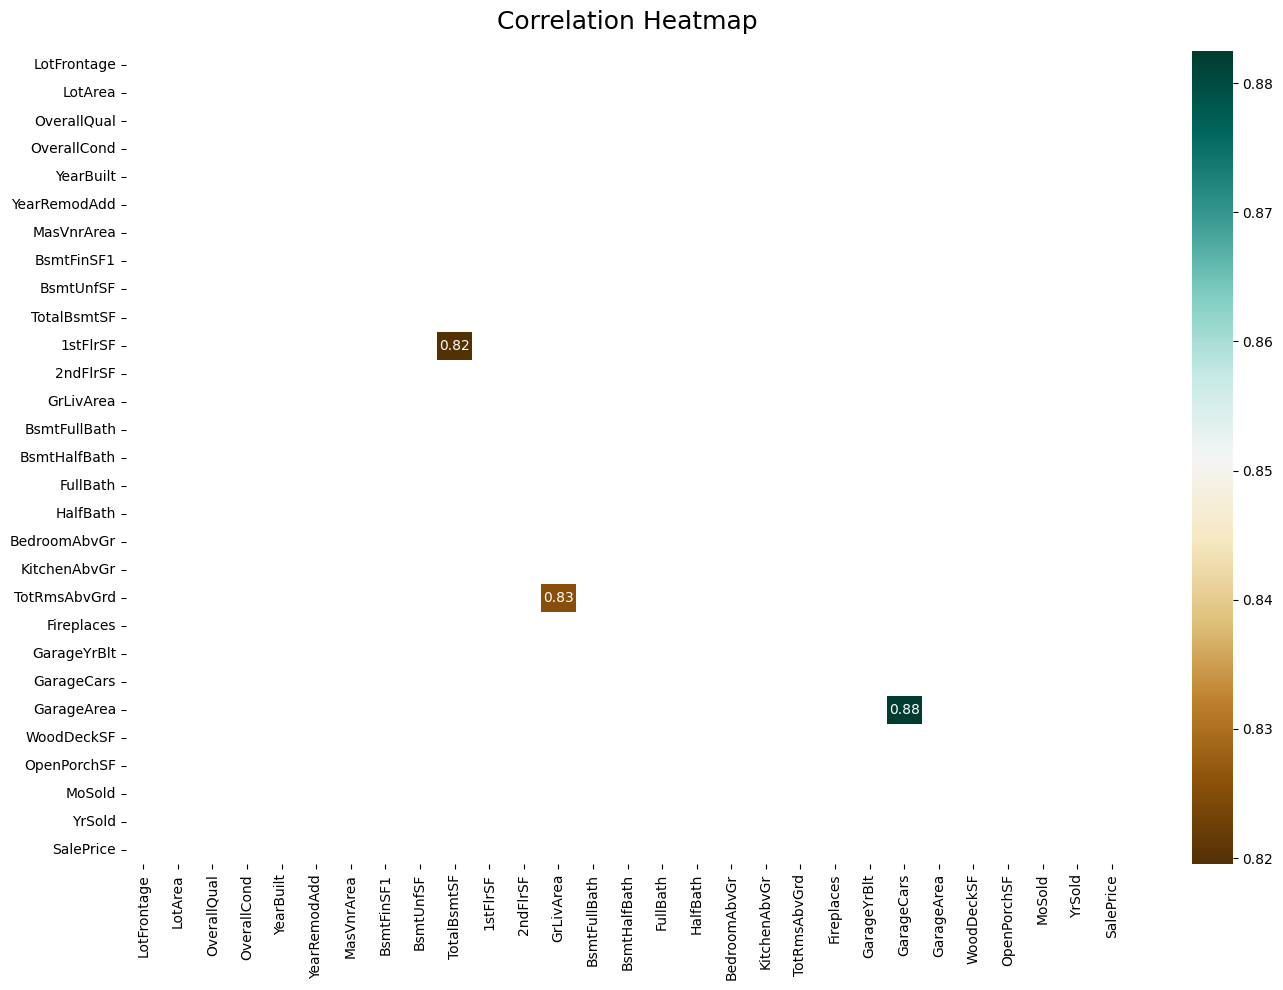

In [12]:
# Correlation HeatMap for numerical variables
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(housing_df[numeric_columns].corr(), dtype=bool))

corr1 = housing_df[numeric_columns].corr()
corr1_filtered = corr1[corr1 >=.8]
heatmap = sns.heatmap(corr1_filtered, mask=mask, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

plt.tight_layout()

del mask, corr1, corr1_filtered, heatmap

In [13]:
# Drop highly correlated columns based on correlation heatmap
col_drop = ["GarageCars", "TotalBsmtSF", "TotRmsAbvGrd"]
housing_df.drop(columns=col_drop, inplace=True)
numeric_columns = [x for x in numeric_columns if x not in col_drop]
del col_drop

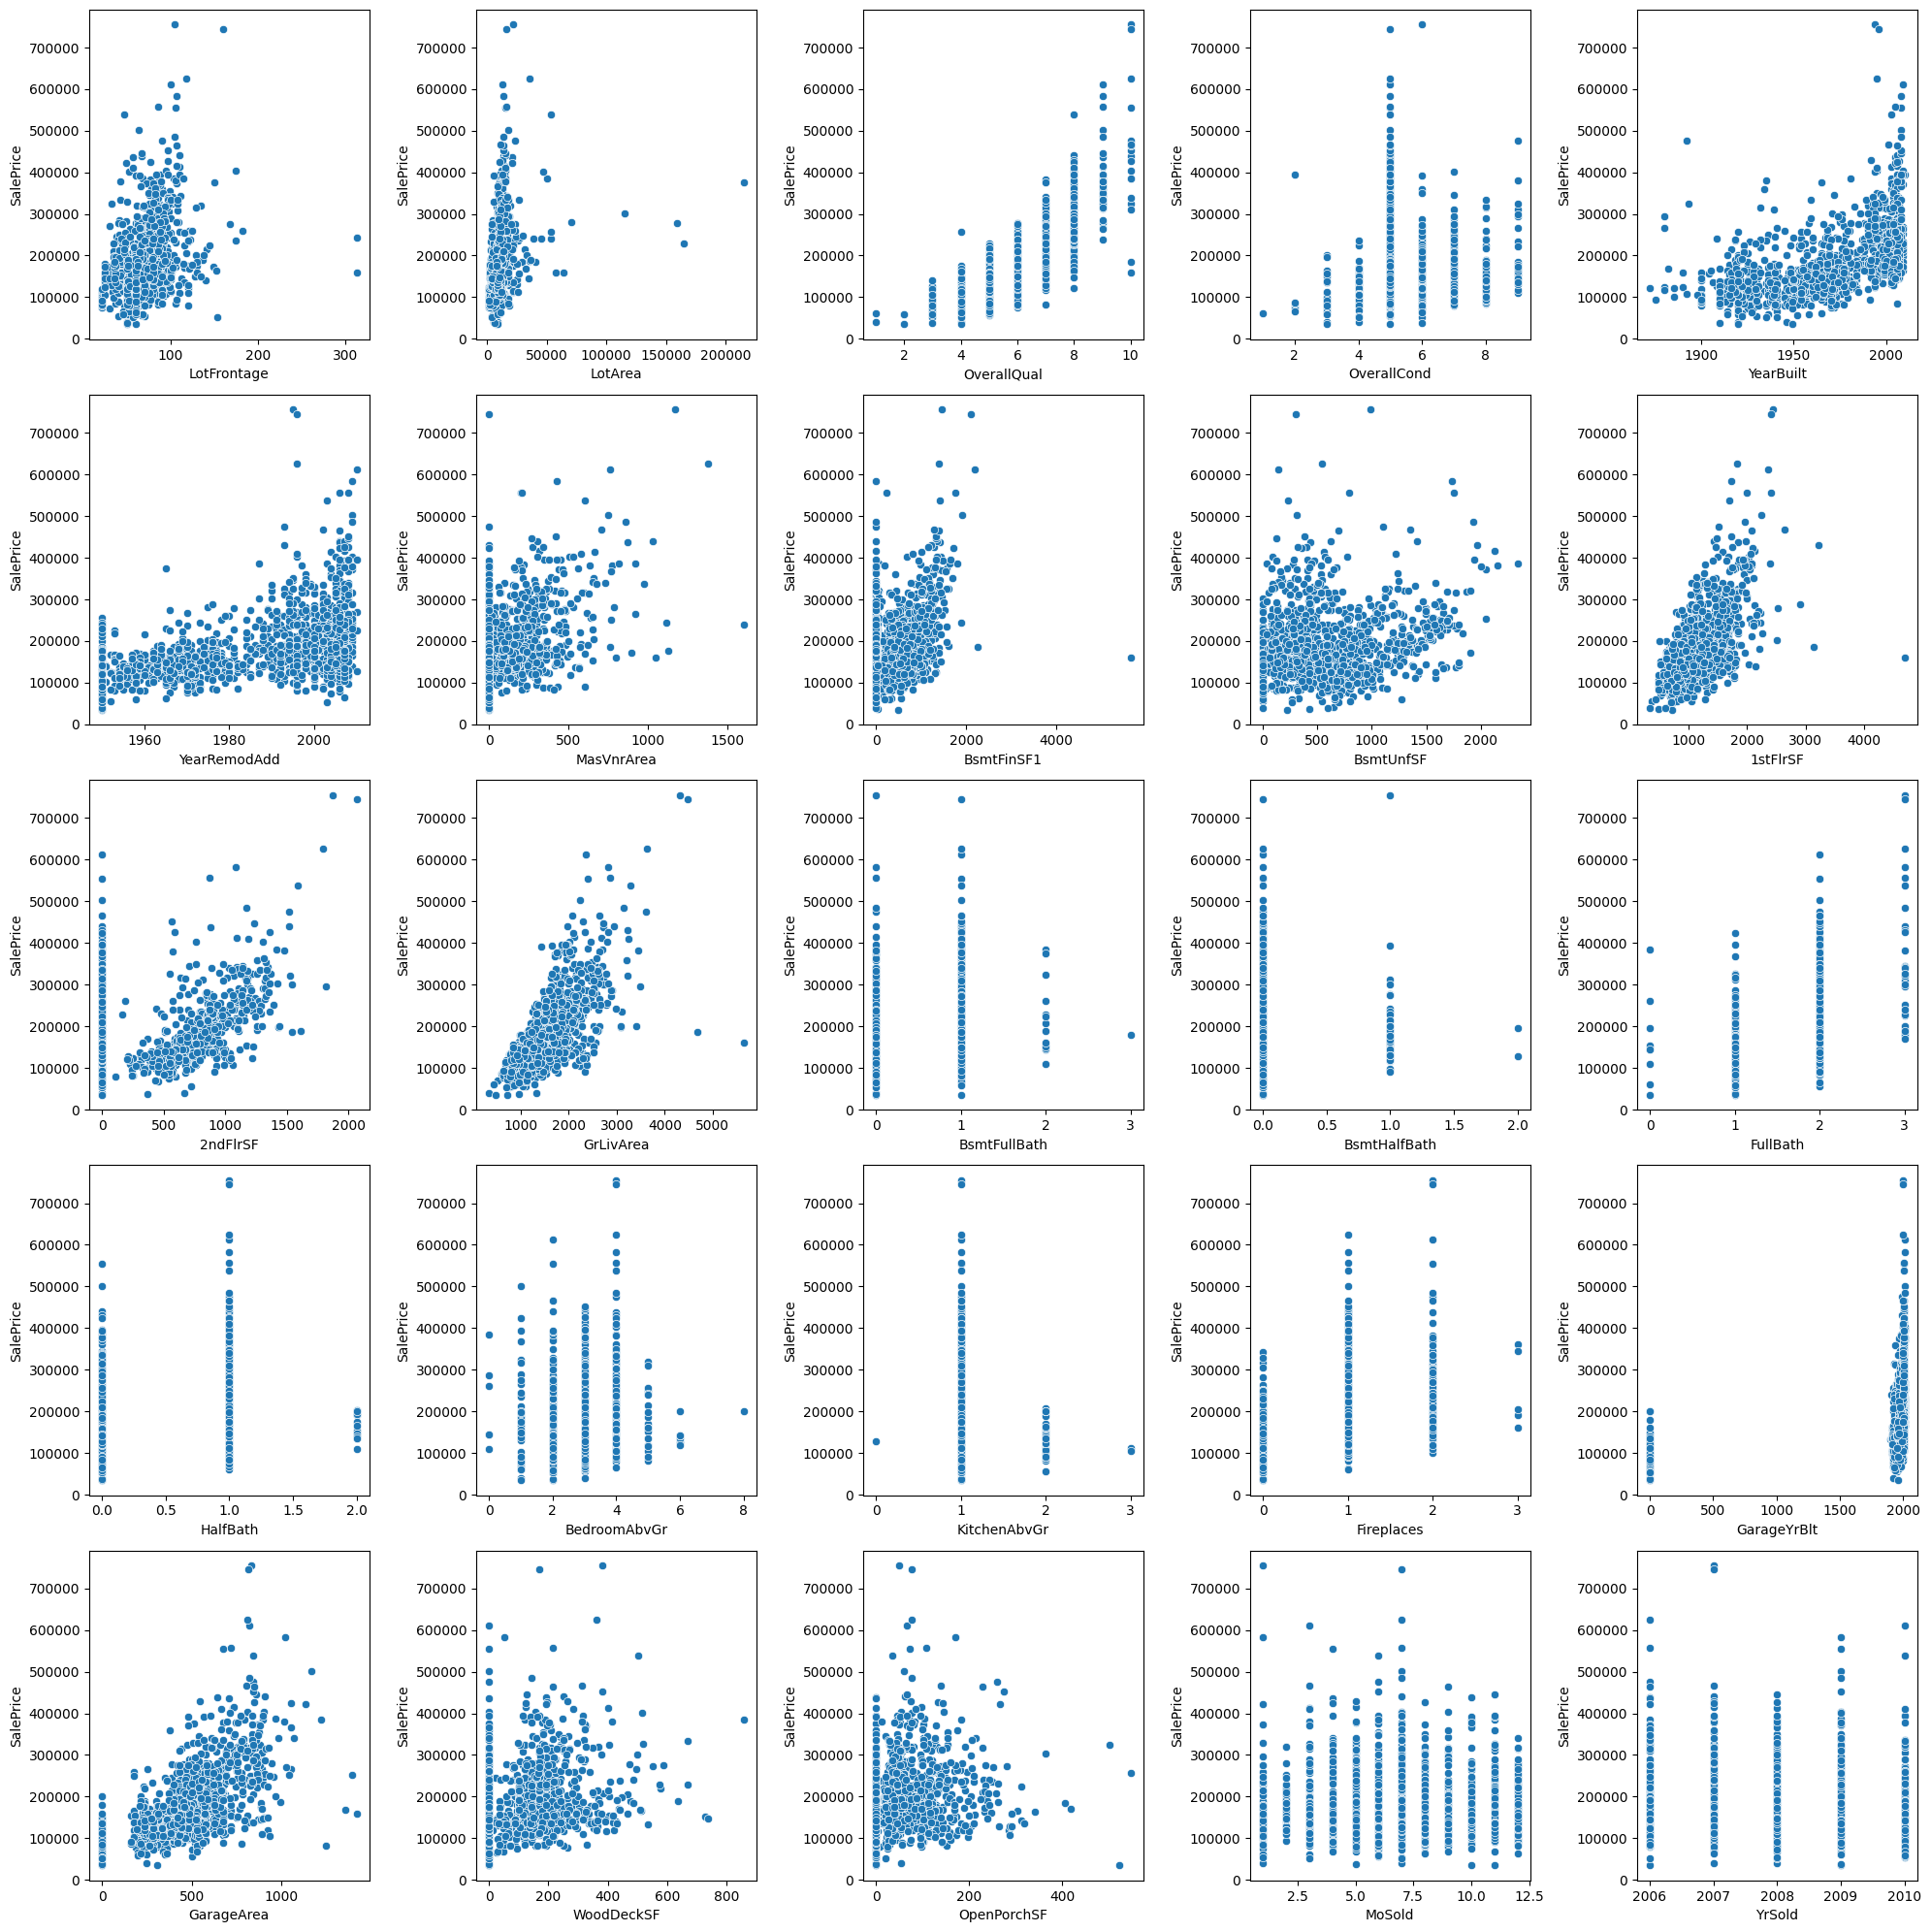

In [14]:
# Scatterplot distribution of numerical features
fig = plt.figure(figsize=(20,20))
temp_forplt = housing_df[numeric_columns]

for index in range(len(temp_forplt.columns)):
    if(index==25):
        break
    plt.subplot(5,5,index+1)
    sns.scatterplot(x=temp_forplt.iloc[:,index], y=temp_forplt.iloc[:,25], data=temp_forplt)

fig.tight_layout(pad=1.0)
del fig, index

In [15]:
# Drop non-correlated variables observed in scatterplot
col_drop = ["MoSold", "YrSold"]
housing_df.drop(columns=col_drop, inplace=True)
numeric_columns = [x for x in numeric_columns if x not in col_drop]
del col_drop

In [16]:
# Add a new feature for total bathroom
housing_df['TotalBathrooms'] = housing_df['BsmtFullBath'] + housing_df['BsmtHalfBath'] + housing_df['FullBath'] + housing_df['HalfBath']

bath_corr = housing_df[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBathrooms', 'SalePrice']].corr()
bath_corr = bath_corr[['SalePrice']].sort_values(['SalePrice'], ascending=False)
print(bath_corr.iloc[1:])
del bath_corr

                SalePrice
TotalBathrooms   0.613005
FullBath         0.560664
HalfBath         0.284108
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844


In [17]:
# Drop old Bathroom columns
col_drop = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
housing_df.drop(columns= col_drop, inplace=True)
numeric_columns = [x for x in numeric_columns if x not in col_drop]
del col_drop

<Axes: xlabel='HouseAge', ylabel='SalePrice'>

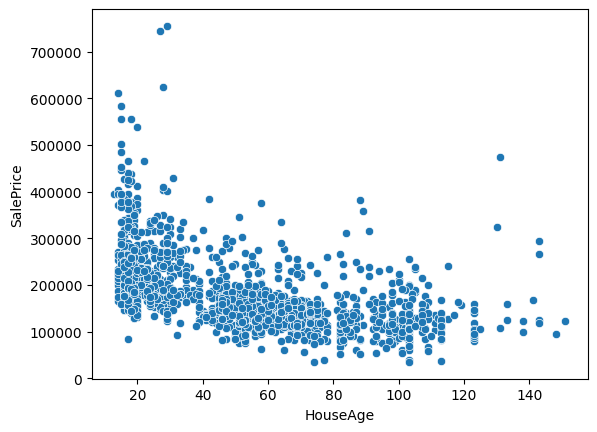

In [18]:
# Age of the house and Has Remodeled?
housing_df['HouseAge'] = 2023 - housing_df['YearBuilt']
sns.scatterplot(x='HouseAge', y='SalePrice', data=housing_df)

<Axes: xlabel='SalePrice', ylabel='Count'>

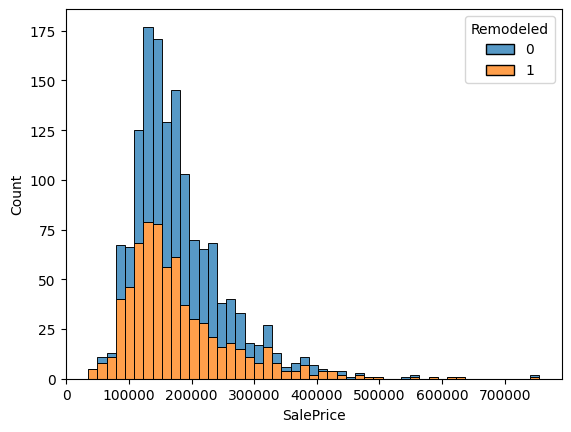

In [19]:
# Has house been Remodeled?
housing_df['Remodeled'] = (housing_df['YearRemodAdd'] - housing_df['YearBuilt'])
housing_df['Remodeled'] = np.where(housing_df['YearRemodAdd'] - housing_df['YearBuilt']!= 0, 1, 0)
sns.histplot(x='SalePrice', hue='Remodeled', multiple='stack', data=housing_df)

In [20]:
# Drop columns
col_drop = ['YearBuilt', 'YearRemodAdd']
housing_df.drop(columns=col_drop, inplace=True)
numeric_columns = [x for x in numeric_columns if x not in col_drop]
del col_drop

## Categorical Variables

In [21]:
categorical_columns = housing_df.select_dtypes(include=['object']).columns.to_list()

In [22]:
# Drop columns with mostly one value (threshold = 95%)
categorical_vars = housing_df[categorical_columns].copy()

overfit_cat = []
for i in categorical_vars:
    counts = categorical_vars[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(categorical_vars) * 100 > 95:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
print(overfit_cat)

del counts, zeros, i, categorical_vars

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']


In [23]:
housing_df.drop(columns=overfit_cat, inplace=True)
categorical_columns = [x for x in categorical_columns if x not in overfit_cat]

In [24]:
ordinal_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                   'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

nominal_columns = [x for x in categorical_columns if x not in ordinal_columns]

del categorical_columns

In [25]:
ordinal_features = housing_df[ordinal_columns]
ordinal_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ExterQual     1460 non-null   object
 1   ExterCond     1460 non-null   object
 2   BsmtQual      1460 non-null   object
 3   BsmtCond      1460 non-null   object
 4   BsmtExposure  1460 non-null   object
 5   BsmtFinType1  1460 non-null   object
 6   BsmtFinType2  1460 non-null   object
 7   HeatingQC     1460 non-null   object
 8   KitchenQual   1460 non-null   object
 9   FireplaceQu   1460 non-null   object
 10  GarageQual    1460 non-null   object
 11  GarageCond    1460 non-null   object
dtypes: object(12)
memory usage: 137.0+ KB


In [26]:
# Encode Ordinal Features
maplist = {'Po': 0, 'Fa': 1,'TA': 2, 'Gd': 3, 'Ex': 4}
ordinal_features['ExterQual'] = ordinal_features['ExterQual'].map(maplist)
ordinal_features['ExterCond'] = ordinal_features['ExterCond'].map(maplist)
ordinal_features['HeatingQC'] = ordinal_features['HeatingQC'].map(maplist)
ordinal_features['KitchenQual'] = ordinal_features['KitchenQual'].map(maplist)
del maplist

maplist = {'Not Present': 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5}
ordinal_features['BsmtQual'] = ordinal_features['BsmtQual'].map(maplist)
ordinal_features['BsmtCond'] = ordinal_features['BsmtCond'].map(maplist)

maplist = {'Not Present': 0, 'No': 1,'Mn': 2, 'Av': 3, 'Gd': 4}
ordinal_features['BsmtExposure'] = ordinal_features['BsmtExposure'].map(maplist)
del maplist

maplist = {'Not Present': 0, 'Unf': 1,'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6}
ordinal_features['BsmtFinType1'] = ordinal_features['BsmtFinType1'].map(maplist)
ordinal_features['BsmtFinType2'] = ordinal_features['BsmtFinType2'].map(maplist)
del maplist

maplist = {'Not Present': 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5}
ordinal_features['FireplaceQu'] = ordinal_features['FireplaceQu'].map(maplist)
del maplist

maplist = {'Not Present': 0, 'Po': 1,'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5}
ordinal_features['GarageQual'] = ordinal_features['GarageQual'].map(maplist)
ordinal_features['GarageCond'] = ordinal_features['GarageCond'].map(maplist)
del maplist

ordinal_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ExterQual     1460 non-null   int64
 1   ExterCond     1460 non-null   int64
 2   BsmtQual      1460 non-null   int64
 3   BsmtCond      1460 non-null   int64
 4   BsmtExposure  1460 non-null   int64
 5   BsmtFinType1  1460 non-null   int64
 6   BsmtFinType2  1460 non-null   int64
 7   HeatingQC     1460 non-null   int64
 8   KitchenQual   1460 non-null   int64
 9   FireplaceQu   1460 non-null   int64
 10  GarageQual    1460 non-null   int64
 11  GarageCond    1460 non-null   int64
dtypes: int64(12)
memory usage: 137.0 KB


C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\321318143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_features['ExterQual'] = ordinal_features['ExterQual'].map(maplist)
C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\321318143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_features['ExterCond'] = ordinal_features['ExterCond'].map(maplist)
C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\321318143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\293529330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_features['SalePrice'] = housing_df['SalePrice']


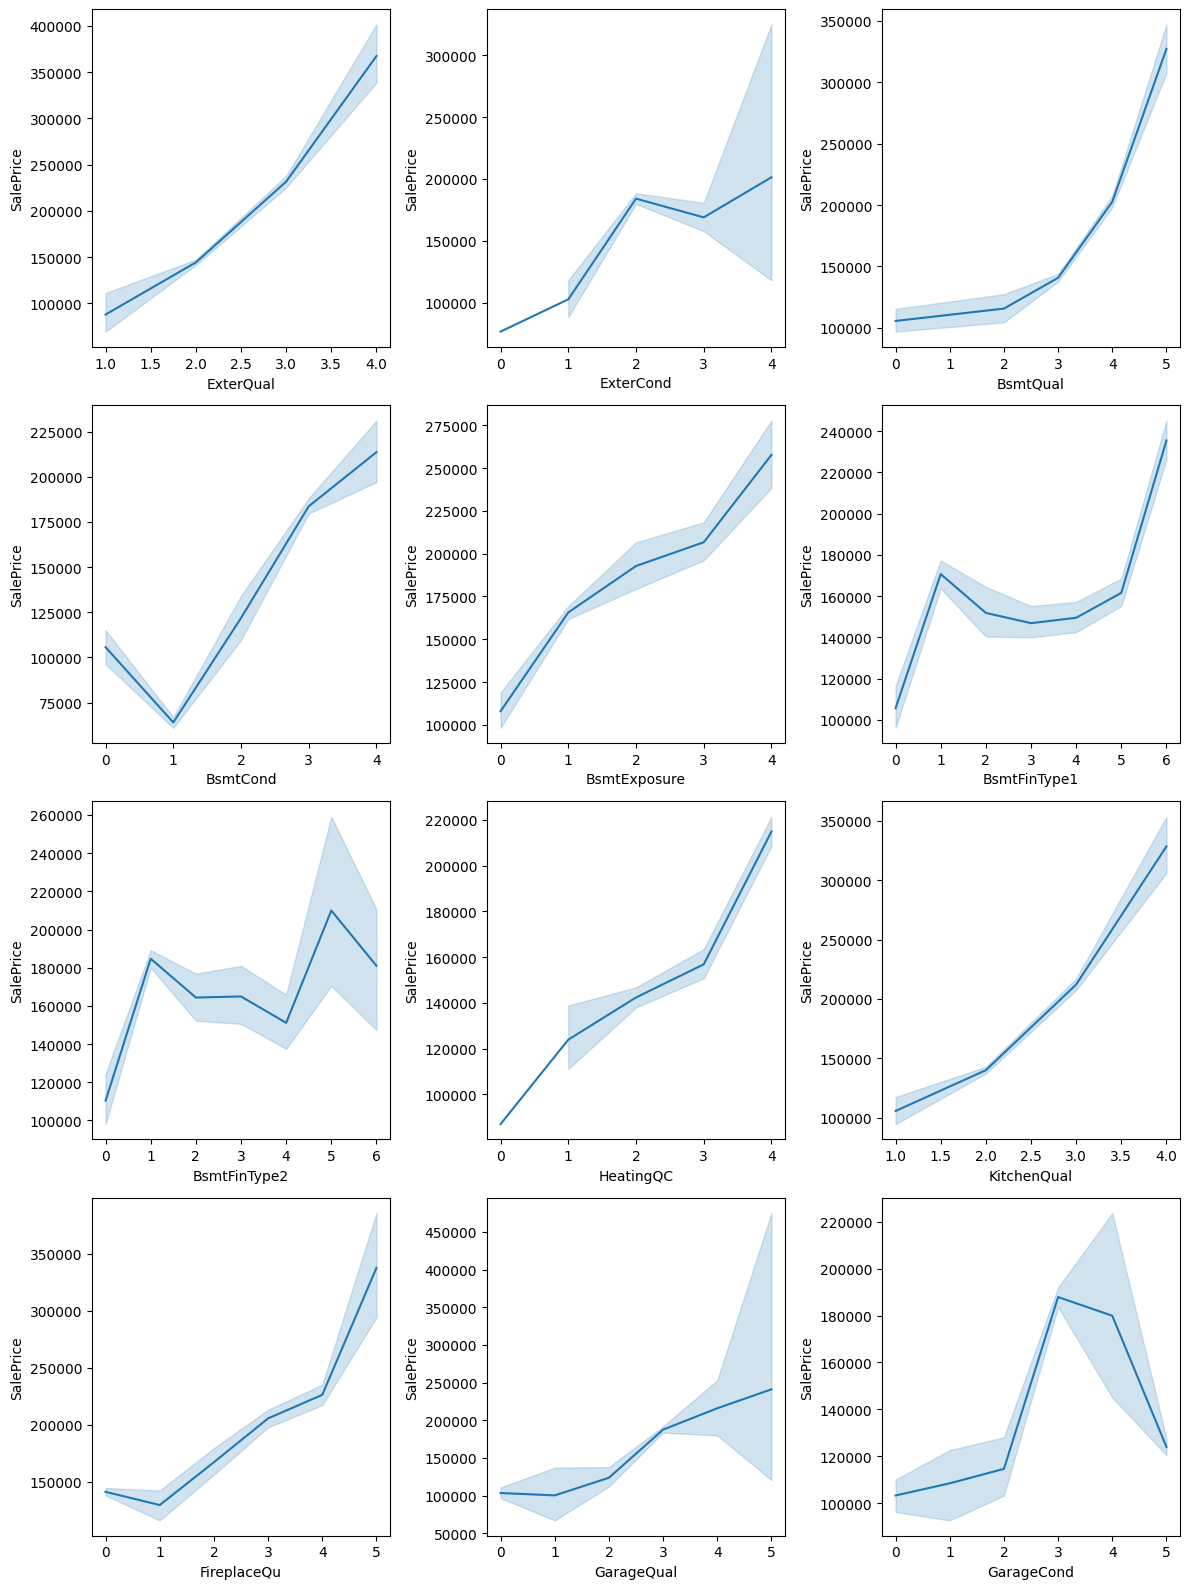

In [27]:
ordinal_features['SalePrice'] = housing_df['SalePrice']
n_rows=4
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,16))

for i, column in enumerate(ordinal_features.columns):
    if(column=='SalePrice'):
        break
    sns.lineplot(data=ordinal_features.dropna(), x=column, y='SalePrice', ax=axes[i//n_cols,i%n_cols])

plt.tight_layout()
del n_cols, n_rows, fig, axes, i, column

In [28]:
# Mutual information between Sale Price & Ordinal Variables
mutual_info = mutual_info_regression(ordinal_features, ordinal_features['SalePrice'])
mutual_info = pd.Series(mutual_info)
mutual_info.index = ordinal_features.columns
mutual_info = mutual_info.sort_values(ascending=False)
print(mutual_info.iloc[1:])

ExterQual       0.336111
KitchenQual     0.332282
BsmtQual        0.331132
FireplaceQu     0.197274
HeatingQC       0.161248
BsmtFinType1    0.078863
GarageCond      0.076769
GarageQual      0.068713
BsmtExposure    0.061312
BsmtCond        0.043424
BsmtFinType2    0.027245
ExterCond       0.014128
dtype: float64


In [29]:
# drop columns with low mutual information
col_drop = ['GarageQual', 'BsmtCond', 'BsmtExposure', 'ExterCond', 'BsmtFinType2']
housing_df.drop(columns=col_drop, inplace=True)
ordinal_features.drop(columns=col_drop, inplace=True)

ordinal_columns = [x for x in ordinal_columns if x not in col_drop]
housing_df.update(ordinal_features)

ordinal_columns = [x for x in ordinal_columns if x not in overfit_cat]

del col_drop, mutual_info

C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\438712990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ordinal_features.drop(columns=col_drop, inplace=True)


## Nominal Variables

C:\Users\chhet\AppData\Local\Temp\ipykernel_7016\2114368223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nominal_features['SalePrice'] = housing_df['SalePrice']


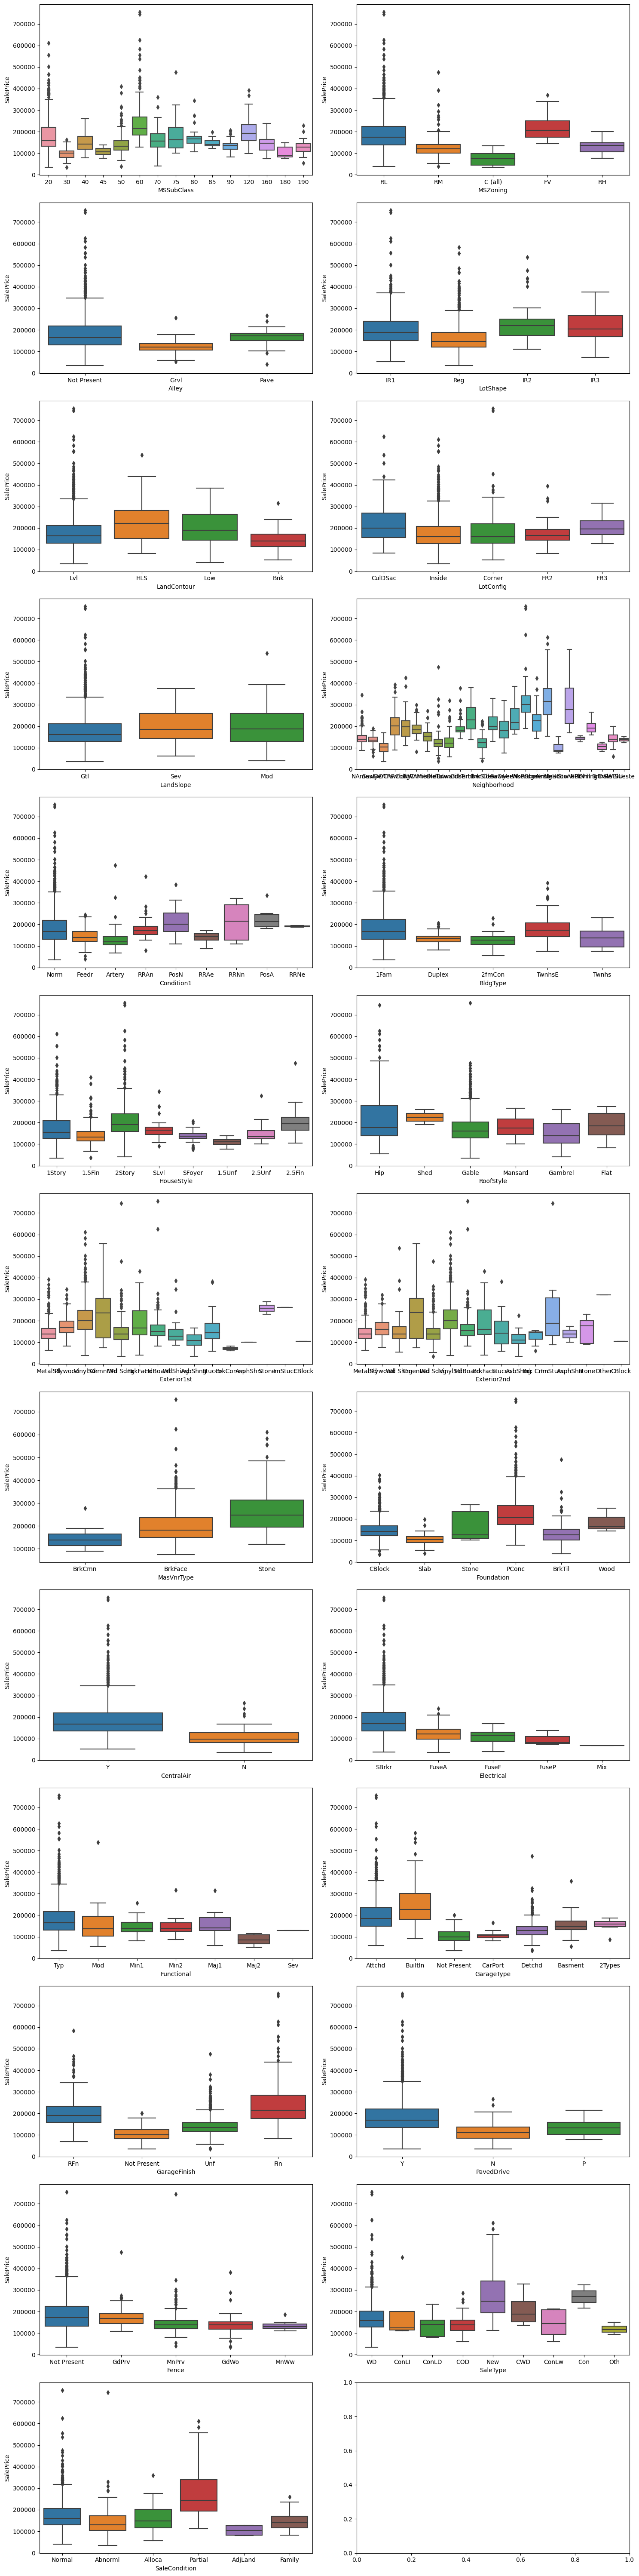

In [30]:
# KDE plot of Nominal Category Variables
nominal_features = housing_df[nominal_columns]
nominal_features['SalePrice'] = housing_df['SalePrice']

n_rows=13
n_cols=2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,60))

for i, column in enumerate(nominal_features.columns):
    if(column=='SalePrice'):
        break
    # sns.kdeplot(data=nominal_features, x="SalePrice", hue=column, ax=axes[i//n_cols,i%n_cols])
    sns.boxplot(data=nominal_features, x=column, y="SalePrice", ax=axes[i//n_cols,i%n_cols])

plt.tight_layout()

del n_rows, n_cols, fig, axes, i, column

In [32]:
# delete features with a high frequency single value (>90%) and multiple categories (>=3)
# cat_col_details = housing_df[nominal_columns].describe()
# print((cat_col_details.iloc[3,:]/1460).sort_values(ascending=False))
# col_drop = ['LandSlope', 'Alley', 'CentralAir', 'Functional', 'PavedDrive', 'Electrical']
# housing_df.drop(columns=col_drop, inplace=True)
# nominal_columns = [x for x in nominal_columns if x not in col_drop]

# del col_drop, ordinal_features, cat_col_details

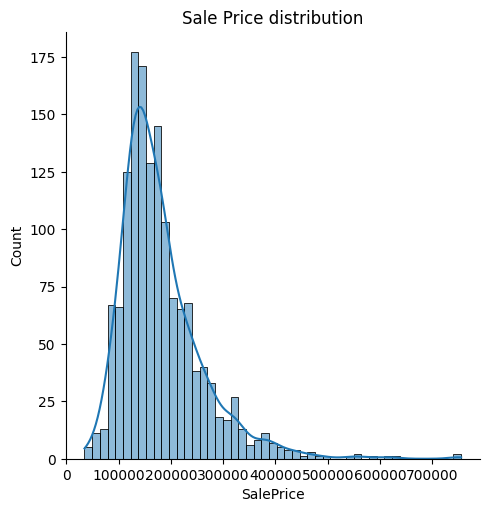

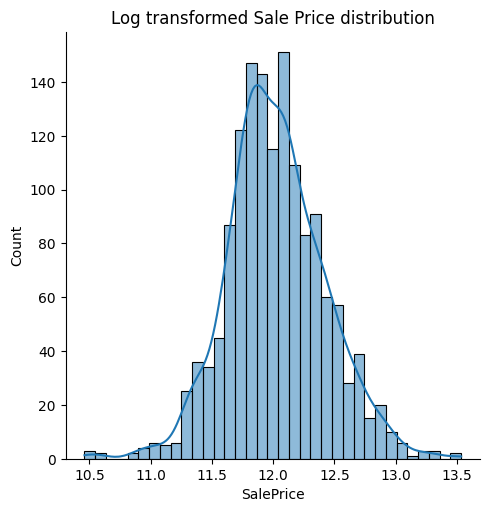

In [36]:
# Check Sale Price distribution
sns.displot(housing_df['SalePrice'], kde=True).set(title='Sale Price distribution')
sns.displot(np.log(housing_df['SalePrice']), kde=True).set(title='Log transformed Sale Price distribution')
plt.show()

In [37]:
# Transforming 'SalePrice'
housing_df['SalePrice_log_trans']= np.log(housing_df['SalePrice'])
# Dropping ID Column and SalePrice
housing_df.drop(columns=['SalePrice','Id'], inplace= True)

In [38]:
# Train-Test Split
y = housing_df['SalePrice_log_trans']
X = housing_df.drop('SalePrice_log_trans', axis= 1)

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size= .7, random_state= 42)

# Get index values of train test dataset
train_index= X_train.index
test_index= X_test.index

In [39]:
# Impute missing values
housing_df.isna().sum().sort_values(ascending=False)

MasVnrType             872
LotFrontage            259
MasVnrArea               8
Electrical               1
MSSubClass               0
GarageYrBlt              0
2ndFlrSF                 0
GrLivArea                0
BedroomAbvGr             0
KitchenAbvGr             0
KitchenQual              0
Functional               0
Fireplaces               0
FireplaceQu              0
GarageType               0
GarageFinish             0
GarageArea               0
GarageCond               0
PavedDrive               0
WoodDeckSF               0
OpenPorchSF              0
Fence                    0
SaleType                 0
SaleCondition            0
TotalBathrooms           0
HouseAge                 0
Remodeled                0
1stFlrSF                 0
HeatingQC                0
CentralAir               0
MSZoning                 0
LotArea                  0
Alley                    0
LotShape                 0
LandContour              0
LotConfig                0
LandSlope                0
N

In [40]:
housing_df['MasVnrType'].fillna(X_train['MasVnrType'].mode()[0], inplace= True)

housing_df['LotFrontage'].fillna(X_train['LotFrontage'].median(), inplace= True)
housing_df['MasVnrArea'].fillna(X_train['MasVnrArea'].median(), inplace= True)

In [41]:
# One hot encoding for nominal features
# Concatenate dummies to replace nominal features
dummies= pd.get_dummies(housing_df[nominal_columns])
housing_df.drop(columns=nominal_columns, inplace=True)

housing_df_cleaned= pd.concat([housing_df, dummies], axis= 1)
print('final shape of housing data', housing_df_cleaned.shape)

final shape of housing data (1460, 208)


In [42]:
# Re-construct Train-test data
X_train= housing_df_cleaned.iloc[train_index, :].drop('SalePrice_log_trans', axis= 1)
y_train= housing_df_cleaned.iloc[train_index, :]['SalePrice_log_trans']
X_test= housing_df_cleaned.iloc[test_index, :].drop('SalePrice_log_trans', axis= 1)
y_test= housing_df_cleaned.iloc[test_index, :]['SalePrice_log_trans']

In [43]:
housing_cat= housing_df_cleaned.select_dtypes(include= 'object')
housing_num= housing_df_cleaned.select_dtypes(exclude= 'object')

In [44]:
# Perform scaling of numeric columns in training and test dataset using RobustScaler
num_cols= housing_num.columns.tolist()
num_cols.remove('SalePrice_log_trans')

scaler= RobustScaler(quantile_range=(2, 98))
scaler.fit(X_train[num_cols])

X_train[num_cols]= scaler.transform(X_train[num_cols])
X_test[num_cols]= scaler.transform(X_test[num_cols])
# Check scaled features
X_train[num_cols].head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1452,0.083333,-0.011024,0.333333,0.0,0.298186,-0.268456,0.658469,0.329889,0.000000,0.065337,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
762,-0.052083,-0.008558,0.166667,0.0,0.000000,-0.268456,0.228980,-0.143084,0.650995,0.139025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
932,-0.031250,-0.034475,-0.166667,0.4,0.000000,0.489374,-0.180519,0.127186,0.699216,0.370898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,-0.333333,0.264631,0.333333,0.0,0.000000,0.281040,-0.007269,0.137785,0.000000,-0.077127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
629,0.041667,0.069482,0.333333,0.0,0.430372,0.113255,0.015750,-0.014573,0.637432,0.225486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
var_t= VarianceThreshold(threshold= .003)
variance_thresh= var_t.fit(X_train)
col_ind= var_t.get_support()

# Below columns have very low variance
X_train.loc[:, ~col_ind].columns

Index(['MSSubClass_40', 'LotConfig_FR3', 'Neighborhood_Blueste',
       'Condition1_RRNe', 'Condition1_RRNn', 'RoofStyle_Shed',
       'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock',
       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn',
       'Exterior2nd_CBlock', 'Exterior2nd_Other', 'Foundation_Wood',
       'Electrical_FuseP', 'Electrical_Mix', 'Functional_Maj2',
       'Functional_Sev', 'GarageType_2Types', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_Oth', 'SaleCondition_AdjLand'],
      dtype='object')

In [46]:
# Checking number of apperance of one of the attributes/categorical value in dataset
org_housing_df.Functional.value_counts()

Functional
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: count, dtype: int64

In [47]:
# Removing above columns from train and test dataset
X_train= X_train.loc[:, col_ind]
X_test= X_test.loc[:, col_ind]
X_train.shape

(1021, 183)

## Model Building

In [48]:
# Select few values for alpha
range1= [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
range2= list(range(2, 1001))
range1.extend(range2)
params_grid= {'alpha': range1}

In [49]:
# Apply Ridge and performing GridSearchCV to find optimal value of alpha (lambda)
ridge= Ridge(random_state= 42)
gcv_ridge= GridSearchCV(estimator= ridge, 
                        param_grid= params_grid,
                        cv= 3,
                        scoring= 'neg_mean_absolute_error',
                        return_train_score= True,
                        n_jobs= -1,
                        verbose= 1)      
gcv_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 1013 candidates, totalling 3039 fits


GridSearchCV(cv=3, estimator=Ridge(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4,
                                   5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                   17, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [51]:
# Checking best estimator 
gcv_ridge.best_estimator_

Ridge(alpha=6, random_state=42)

In [52]:
# Checking best MAE
gcv_ridge.best_score_

-0.09225270494966886

In [53]:
# Fitting model using best_estimator_
ridge_model= gcv_ridge.best_estimator_
ridge_model.fit(X_train, y_train)

Ridge(alpha=6, random_state=42)

In [54]:
# Evaluating on training dataset
y_train_pred= ridge_model.predict(X_train)
print( 'r2 score on training dataset:', r2_score(y_train, y_train_pred))
print( 'MSE on training dataset:', mean_squared_error(y_train, y_train_pred))
print( 'RMSE on training dataset:', (mean_squared_error(y_train, y_train_pred)**.5))
print( 'MAE on training dataset:', mean_absolute_error(y_train, y_train_pred))

r2 score on training dataset: 0.9225520103165792
MSE on training dataset: 0.012795132086010862
RMSE on training dataset: 0.11311556960034663
MAE on training dataset: 0.07609958400464137


In [55]:
# Evaluating on testing dataset
y_test_pred= ridge_model.predict(X_test)
print( 'r2 score on testing dataset:', r2_score(y_test, y_test_pred))
print( 'MSE on testing dataset:', mean_squared_error(y_test, y_test_pred))
print( 'RMSE on testing dataset:', (mean_squared_error(y_test, y_test_pred)**.5))
print( 'MAE on testing dataset:', mean_absolute_error(y_test, y_test_pred))

r2 score on testing dataset: 0.853856056123418
MSE on testing dataset: 0.021324717418909542
RMSE on testing dataset: 0.1460298511226713
MAE on testing dataset: 0.09498582080266005


In [56]:
# Ridge coefficients
ridge_model.coef_

array([-0.03917253,  0.04362032,  0.26009622,  0.14497607,  0.02902856,
        0.01046978,  0.0343588 ,  0.01254931, -0.01163217,  0.00733812,
        0.01504459,  0.18108067,  0.10548081,  0.22414257,  0.02973721,
       -0.03004862,  0.03870602, -0.02043169,  0.0193667 ,  0.00343275,
        0.11849286,  0.00883232,  0.03330813,  0.050088  ,  0.13077116,
       -0.08915611,  0.00328269,  0.01389486, -0.06912476, -0.02572794,
        0.03638825, -0.01635769,  0.04300523,  0.04067625,  0.01738287,
        0.02424882,  0.03561844, -0.01207599, -0.06067222, -0.02226183,
        0.00621376, -0.0881096 ,  0.01963954,  0.01010363,  0.05565681,
        0.00270962,  0.01573868, -0.01288633, -0.00285235,  0.02091901,
        0.03832539, -0.08683865,  0.02759425, -0.04319414,  0.02769618,
        0.00441662,  0.01108134,  0.00351123,  0.02898699, -0.02078241,
       -0.00084202, -0.00135384,  0.0132291 , -0.01187526, -0.0026282 ,
       -0.01350702,  0.00419036,  0.05678949, -0.019697  ,  0.07

In [57]:
# Ridge intercept
ridge_model.intercept_

11.53884371060951

In [58]:
# Top 10 features with double the value of optimal alpha in Ridge
ridge_coef= pd.Series(ridge_model.coef_, index= X_train.columns)
top_25_ridge=  ridge_coef[abs(ridge_coef).nlargest(25).index]
top_25_ridge

OverallQual             0.260096
GrLivArea               0.224143
1stFlrSF                0.181081
OverallCond             0.144976
TotalBathrooms          0.130771
GarageArea              0.118493
Neighborhood_MeadowV   -0.110603
Neighborhood_StoneBr    0.105731
2ndFlrSF                0.105481
Exterior1st_BrkFace     0.092275
HouseAge               -0.089156
MSZoning_C (all)       -0.088110
Neighborhood_Edwards   -0.086996
LotShape_IR3           -0.086839
Neighborhood_NridgHt    0.086730
Neighborhood_Crawfor    0.075990
Functional_Typ          0.073570
Exterior2nd_Stucco     -0.072509
Functional_Min1         0.069838
MSSubClass_30          -0.069125
BldgType_Twnhs         -0.063214
Neighborhood_NoRidge    0.062924
MSSubClass_160         -0.060672
Neighborhood_ClearCr    0.056789
MSZoning_RL             0.055657
dtype: float64

## Lasso Regression

In [59]:
# Applying Lasso and performing GridSearchCV to find optimal value of alpha (lambda)
params_grid= {'alpha': range1}
lasso= Lasso(random_state= 42)
lasso_gcv= GridSearchCV(estimator= lasso, 
                        param_grid= params_grid,
                        cv= 3,
                        scoring= 'neg_mean_absolute_error',
                        return_train_score= True,
                        n_jobs= -1,
                        verbose= 1)

lasso_gcv.fit(X_train, y_train)   

Fitting 3 folds for each of 1013 candidates, totalling 3039 fits


GridSearchCV(cv=3, estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4,
                                   5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                   17, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [60]:
# Checking best estimator 
print(lasso_gcv.best_estimator_)
# Checking best MAE
print(lasso_gcv.best_score_)

Lasso(alpha=0.001, random_state=42)
-0.08987521100415226


In [61]:
range3= [0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001]
params_grid= {'alpha': range3}
lasso_gcv= GridSearchCV(estimator= lasso, 
                        param_grid= params_grid,
                        cv= 3,
                        scoring= 'neg_mean_absolute_error',
                        return_train_score= True,
                        n_jobs= -1,
                        verbose= 1)

lasso_gcv.fit(X_train, y_train) 

Fitting 3 folds for each of 15 candidates, totalling 45 fits


GridSearchCV(cv=3, estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001,
                                   0.0002, 0.0003, 0.0004, 0.0005, 0.0006,
                                   0.0007, 0.0008, 0.0009, 0.001]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [62]:
# Checking best estimator 
lasso_gcv.best_estimator_

Lasso(alpha=0.0007, random_state=42)

In [63]:
# Fitting model using best_estimator_
lasso_model= lasso_gcv.best_estimator_
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.0007, random_state=42)

In [64]:
# Evaluating on training dataset
y_train_pred= lasso_model.predict(X_train)
print( 'r2 score on training dataset:', r2_score(y_train, y_train_pred))
print( 'MSE on training dataset:', mean_squared_error(y_train, y_train_pred))
print( 'RMSE on training dataset:', (mean_squared_error(y_train, y_train_pred)**.5))
print( 'MAE on training dataset:', mean_absolute_error(y_train, y_train_pred))

r2 score on training dataset: 0.9165378090623688
MSE on training dataset: 0.0137887343699956
RMSE on training dataset: 0.11742544174920357
MAE on training dataset: 0.077776418151723


In [65]:
# Evaluating on testing dataset
y_test_pred= lasso_model.predict(X_test)
print( 'r2 score on testing dataset:', r2_score(y_test, y_test_pred))
print( 'MSE on testing dataset:', mean_squared_error(y_test, y_test_pred))
print( 'RMSE on testing dataset:', (mean_squared_error(y_test, y_test_pred)**.5))
print( 'MAE on testing dataset:', mean_absolute_error(y_test, y_test_pred))

r2 score on testing dataset: 0.8564844049815208
MSE on testing dataset: 0.020941199667912698
RMSE on testing dataset: 0.14471074482536775
MAE on testing dataset: 0.09356044245943422


In [66]:
# Checking no. of features in Ridge and Lasso models
lasso_coef= pd.Series(lasso_model.coef_, index= X_train.columns)
selected_features= len(lasso_coef[lasso_coef != 0])
print('Features selected by Lasso:', selected_features)
print('Features present in Ridge:', X_train.shape[1])

Features selected by Lasso: 77
Features present in Ridge: 183


In [67]:
# Lasso intercept
lasso_model.intercept_

11.593977389065635

In [68]:
# Top 25 features with coefficients in Lasso model
top25_features_lasso=  lasso_coef[abs(lasso_coef[lasso_coef != 0]).nlargest(25).index]
top25_features_lasso

GrLivArea                0.392792
OverallQual              0.348405
OverallCond              0.170810
HouseAge                -0.136570
TotalBathrooms           0.130106
GarageArea               0.114572
LotShape_IR3            -0.103349
Neighborhood_StoneBr     0.098815
Exterior1st_BrkFace      0.097433
1stFlrSF                 0.091950
Neighborhood_NridgHt     0.090358
Exterior2nd_Stucco      -0.089740
Neighborhood_Crawfor     0.083834
SaleCondition_Abnorml   -0.077642
Neighborhood_Somerst     0.074611
Neighborhood_MeadowV    -0.065758
MSSubClass_160          -0.060774
Functional_Typ           0.059514
MSZoning_RL              0.057601
Neighborhood_Edwards    -0.055164
Neighborhood_ClearCr     0.052367
BldgType_Twnhs          -0.049638
Neighborhood_NoRidge     0.048920
MSZoning_C (all)        -0.048308
Condition1_Norm          0.045594
dtype: float64

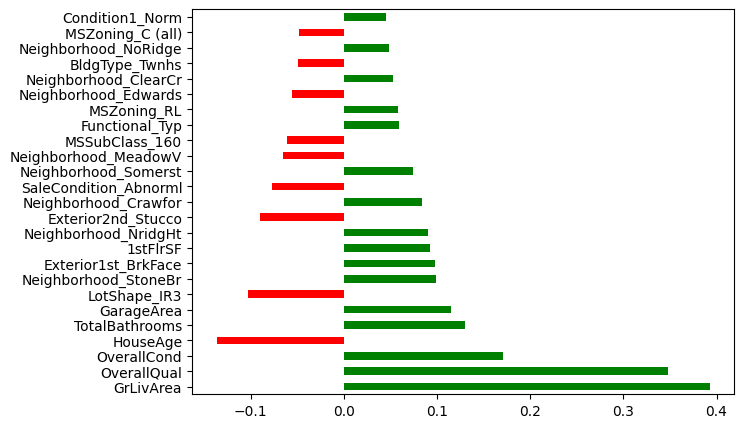

In [69]:
# Ploting top 25 features
plt.figure(figsize= (7, 5))
top25_features_lasso.plot.barh(color= (top25_features_lasso > 0).map({True: 'g', False: 'r'}))
plt.show()

## Conclusion

As both Ridge and Lasso models have almost same test and train accuracy, we can say that there is no overfitting.


Lasso and Ridge both have similar r2 score and MAE on test dataset.  
Ridge Regression model on test dataset: r2 score= 0.854, MAE= 0.094, RMSE= 0.146  
Lasso Regression model on test dataset: r2 score= 0.856, MAE= 0.093, RMSE= 0.144  

The final no. of features in Lasso Regression model is 77. Whereas Ridge has 183 features.  
So, Lasso model is simpler than Ridge while having similar r2 score and MAE.  

Considering above points we can choose our Lasso Regression model as our final model.

